# Mass reconstruction projections

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from tqdm import tqdm
import swordfish as sf
from WIMpy import DMUtils as DMU
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz, quad
from scipy.special import erf
from paleo.paleopy_classes import *
import paleo.paleopy as paleopy
import os
import h5py 

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
rc('font', size=16)
#mpl.rcParams.update({'font.size': 16,'font.family':'serif'})

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

#%matplotlib inline

Now we can load in the material we are interested in i.e. Sinjarite since its the most sensitive

In [2]:
Sinj = Mineral("Sinjarite")

#### Backgrounds

Lets load the backgrounds now

In [3]:
xb = paleopy.calcBins_1nm()
N_BG_1nm_test = paleopy.GetBackground(Sinj, 1.0)
N_BG_1nm = paleopy.GetBackground(Sinj, sigma=1.0, x_bins=xb)
N_BG_15nm = paleopy.GetBackground(Sinj, 15.0)

 DMutils.py: Loading neutrino flux for the first time...
Loading neutrino fluxes for...
    DSNB
    atm
    hep
    8B
    15O
    17F
    pep
    13N
    pp
    7Be-384
    7Be-861
...done.


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [4]:
print(np.shape(N_BG_1nm))

(13, 190)


Quickly look to see they are sensible...

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

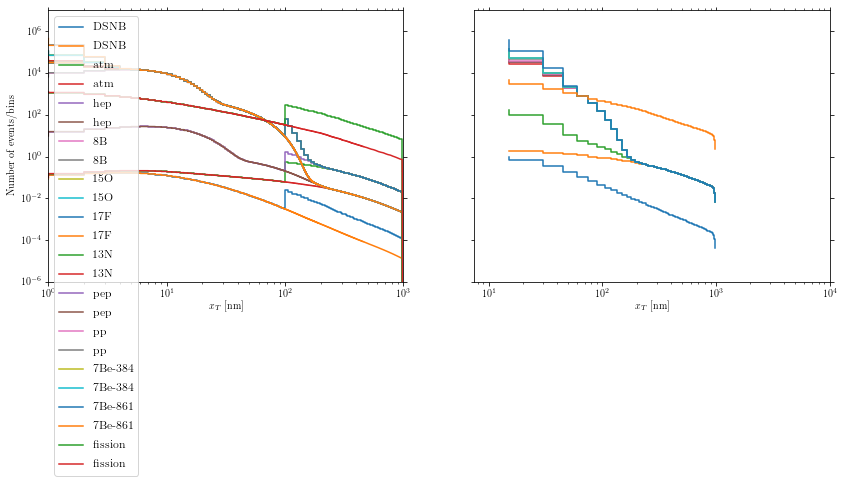

In [5]:
bkg_list = ['DSNB', 'atm', 'hep', '8B', '15O', '17F', '13N', 'pep','pp','7Be-384','7Be-861', 'fission']

f, axarr = plt.subplots(figsize=(14,5), nrows=1, ncols=2, sharey=True)

ax1, ax2 = axarr

ax1.set_xscale("log")
ax1.set_yscale("log")

for i,bkg in enumerate(bkg_list):
    ax1.step(xb[:-1] + np.diff(xb)/2, N_BG_1nm[i], label=bkg)
    ax1.step(paleopy.calcBins(1.0)[:-1] + 1./2, N_BG_1nm_test[i], label=bkg)

ax1.legend(fontsize=12)
ax1.set_ylim(1e-6, 1e7)
ax1.set_xlim(1, 1000)

ax1.set_ylabel(r"Number of events/bins")
ax1.set_xlabel(r"$x_T$ [nm]")

#------------------

ax2.set_xscale("log")
ax2.set_yscale("log")

for i,bkg in enumerate(bkg_list):
    ax2.step(paleopy.calcBins(15.0)[:-1] + 15.0/2, N_BG_15nm[i], label=bkg)

ax2.set_ylim(1e-6, 1e7)
ax2.set_xlim(7.5, 10000)
    
ax2.set_xlabel(r"$x_T$ [nm]")
    
#ax2.legend()
#ax2.legend(fontsize=12)

#f.subplots_adjust(hspace=0.001)

plt.show()

#### Lets now make some Euclideanized signals

The region we will consider is between the 95% CL and three orders of magnitude above that. This roughly corresponds to the current sensitivity of Xenon detectors.

In [24]:
m_lim, Sinj_lim = np.loadtxt('../ES/limits/lims_Sinj_exp100.0_res15.0.txt', unpack=True, usecols=(0,1))
lim = interp1d(m_lim, Sinj_lim, bounds_error=False, fill_value='extrapolate')

mlist = np.logspace(np.log10(6),4,num=100)
nsamples = 100
ref_sig = 1e-46
systematics = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e-3, 1e-3]

forceRecalculate = False

ESfile = '../ES/hdf5/Sinj_15nm.hdf5'

if (forceRecalculate):
    os.remove(ESfile)

if not(os.path.isfile(ESfile)):
    print ("HDF file not found. Calculating ES from scratch...")
    
    couplings = []
    mass = []
    ESSinj = []
    NSinj = [] 

    for m in tqdm(mlist, desc="Euclideanizing Sinj"):
        coupling_temp = np.logspace(np.log10(lim(m)),np.log10(lim(m)*100), nsamples)
        for c_temp in coupling_temp:
            couplings.append(c_temp)
            mass.append(m)
        
#             sig = gaussian_filter1d(dRdx(x_bins, c_temp, m, rock='Syl'),1)+1e-20
#             SF = sf.Swordfish(dRdx_Sylnu, T=systematics, E=np.ones_like(dRdx_Sylnu[0])*10)
            
            SF = sf.Swordfish(N_BG_15nm, T=systematics, E=np.ones_like(N_BG_15nm[0])*100.)
            sig = paleopy.GetSignal(Sinj, 15.0, m_DM=m, xsec=c_temp)
#             print(np.shape(sig))
            NSinj.append(sum(sig))
            ES_temp = SF.euclideanizedsignal(sig)
            ESSinj.append(ES_temp)

    couplings = np.array(couplings)
    mass = np.array(mass)
    ESSinj = np.array(ESSinj)
    NSinj = np.array(NSinj)

    # Output to new hdf5
    hf = h5py.File(ESfile, 'w')
    hf.create_dataset('ESSinj', data=ESSinj)
    hf.create_dataset('mass', data=mass)
    hf.create_dataset('c', data=couplings)
    hf.create_dataset('NSinj', data=NSinj)
    hf.close()

Euclideanizing Sinj:   0%|          | 0/100 [00:00<?, ?it/s]

HDF file not found. Calculating ES from scratch...


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
Euclideanizing Sinj: 100%|██████████| 100/100 [2:01:34<00:00, 72.95s/it]


#### We can now try to assess how good at reconstruction Sinj is

In [7]:
root = h5py.File(ESfile)
ESSinj = np.array(root['ESSinj'])
sigmaSI = np.array(root['c'])
mass = np.array(root['mass'])
c = np.zeros([sigmaSI.shape[0], 2])
N = np.array(root['NSinj'])
c[:,0] = mass
c[:,1] = sigmaSI
print(c.shape,ESSinj.shape)

(10000, 2) (10000, 66)


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


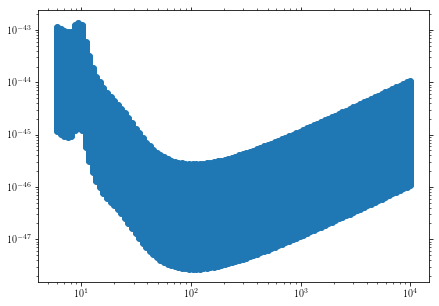

In [8]:
fig, ax = plt.subplots(figsize=(7,5))

ax.set_xscale('log')
ax.set_yscale('log')

plt.scatter(mass, sigmaSI)

plt.show()


In [9]:
shSinj = sf.SignalHandler(c, ESSinj,verbose=True)

Initializing ball trees for nearest neighbour searches...
...done!


[1.26937669e+01 1.91427826e-46] 6284.150276654915


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


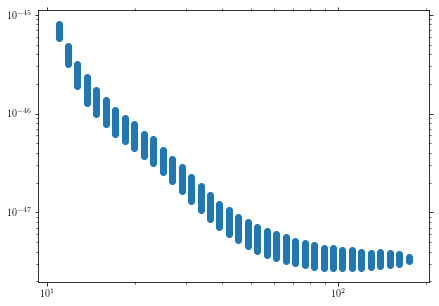

In [10]:
i = 1000
P0 = c[i,:]
print(P0,N[i])
pp, el_ind = shSinj.query_region(P0, sigma=1.0, d=1, return_indices = True)
# print(N[el_ind])
fig, ax = plt.subplots(figsize=(7,5))

ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(pp[:,0], pp[:,1])
plt.show()

Query 2-sigma regions around each point and check whether mass discrimination is possible...

In [11]:
m_listSinj = []
sigma_list_Sinj = []

for i in tqdm(range(len(c[:,0]))):
    P0 = c[i,:]
    
    if(P0[1] < 1e-35):
        pp, el_ind = shSinj.query_region(P0, sigma=2.0, d=1, return_indices = True)
        if pp.size == 0.0:
            continue
        if np.max(pp[:,0]) == np.max(mass):
            m_listSinj.append(c[i,0])
            sigma_list_Sinj.append(c[i,1])

 13%|█▎        | 1327/10000 [00:01<00:12, 707.50it/s]/usr/local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.206606e-18
  overwrite_a=True).T
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.222790e-17
  overwrite_a=True).T
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.013326e-16
  overwrite_a=True).T
 15%|█▍        | 1480/10000 [00:02<00:11, 710.95it/s]/usr/local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guarant

Analyse and plot the results

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

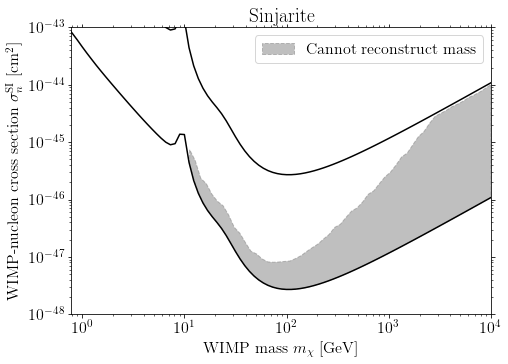

In [12]:
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
rc('font', size=16)
plt.figure(figsize=(7,5))
from scipy.stats import binned_statistic
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

plt.plot(m_lim, Sinj_lim, 'k', )
plt.plot(m_lim, Sinj_lim*100, 'k')

# plt.scatter(m_listSinj, sigma_list_Sinj)

percentile = lambda x: np.percentile(x, 99.)
line, bins, _ = binned_statistic(m_listSinj, sigma_list_Sinj,
                                 percentile, bins=np.logspace(np.log10(6),4.,num=60))
bin_c = bins[:-1] + np.diff(bins)

# plt.plot(bin_c,line, 'k')
temp = interp1d(m_lim, Sinj_lim)
plt.fill_between(bin_c,line, temp(bin_c), linestyle='--', color='grey', alpha=0.5,
                                     label=r'Cannot reconstruct mass')
plt.xlabel(r'WIMP mass $m_\chi$ [GeV]')
plt.ylabel(r'WIMP-nucleon cross section $\sigma_n^{\mathrm{SI}}$ [cm$^2$]')
plt.xlim(np.log10(6),10000)
plt.ylim(1e-48,1e-43)
plt.title(r'Sinjarite')
plt.legend()
plt.tight_layout(pad=0.3)
plt.savefig("../plots/mass_reconstruction_15nm.pdf")
plt.show()

In [13]:
# def plot_ellipse(ind, txt=None, x=False, colour=False):
#     P0 = c[ind,:]
#     pp2, el_ind2, d2 = shSinj.query_region(P0, sigma=3., d=2, return_distance = True)
# #     print(len(el_ind2))
# #     NOTE: Return points within 3 sigma in 2 dimensions to make contours smooth
#     if len(el_ind2) < 20:
#         return None
#     if x:
#         plt.annotate(txt, (np.log10(mass[ind]), np.log10(c[ind,1])))
#         plt.plot(np.log10(mass[ind]), np.log10(c[ind,1]), 'x', color='k')
#     elif colour:
#         z = np.ones_like(mass[el_ind2])
#         x = mass[el_ind2]
#         y = c[el_ind2,1]
# #         print(x,y,z)
# #     NOTE: levels indicates the radius of the contour, 1.5152 is 95%CL in 2 dimensions
#         plt.tricontour(np.log10(x), np.log10(y), d2, colors=['green', 'green'], levels=[0, 2.4859,])
            
# # levels=[0, 1.515, 2.4859,]        

# fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4))        

# b = shSinj.get_benchmarks2(sigma=2.4859)
# for i in b:
#     plot_ellipse(i, colour=True)
    
# plt.plot(np.log10(m_lim), np.log10(Sinj_lim), 'k', linestyle='--')
# plt.plot(np.log10(m_lim), np.log10(Sinj_lim*100), 'k', linestyle='--')
# plt.xlim(np.log10(6),np.log10(10000))
# plt.ylim(-48,-43)
# plt.savefig("../plots/mass_reconstruction_green_elipses.pdf")
# plt.plot()

#### 1nm Case

Now lets do it for the 1nm case

In [23]:
m_lim, Sinj_lim_1nm = np.loadtxt('../ES/limits/lims_Sinj_exp1.0_res1.0.txt', unpack=True, usecols=(0,1))
lim = interp1d(m_lim, Sinj_lim_1nm, bounds_error=False, fill_value='extrapolate')

mlist = np.logspace(np.log10(6),4,num=100)
nsamples = 100
ref_sig = 1e-46
systematics = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e-3, 1e-3]

forceRecalculate = False

ESfile_1nm = '../ES/hdf5/Sinj_1nm.hdf5'

if (forceRecalculate):
    os.remove(ESfile_1nm)

if not(os.path.isfile(ESfile_1nm)):
    print ("HDF file not found. Calculating ES from scratch...")
    
    couplings = []
    mass = []
    ESSinj_1nm = []
    NSinj = [] 

    for m in tqdm(mlist, desc="Euclideanizing Sinj"):
        coupling_temp = np.logspace(np.log10(lim(m)),np.log10(lim(m)*100), nsamples)
        for c_temp in coupling_temp:
            couplings.append(c_temp)
            mass.append(m)
            
            SF1nm = sf.Swordfish(N_BG_1nm, T=systematics, E=np.ones_like(N_BG_1nm[0]))
            sig = paleopy.GetSignal(Sinj, sigma=1.0, x_bins=xb, m_DM=m, xsec=c_temp)

            NSinj.append(sum(sig))
            ES_1nm = SF1nm.euclideanizedsignal(sig)
            ESSinj_1nm.append(ES_1nm)

    couplings = np.array(couplings)
    mass = np.array(mass)
    ESSinj_1nm = np.array(ESSinj_1nm)
    NSinj = np.array(NSinj)

    # Output to new hdf5
    hf = h5py.File(ESfile_1nm, 'w')
    hf.create_dataset('ESSinj', data=ESSinj_1nm)
    hf.create_dataset('mass', data=mass)
    hf.create_dataset('c', data=couplings)
    hf.create_dataset('NSinj', data=NSinj)
    hf.close()

Euclideanizing Sinj:   0%|          | 0/100 [00:00<?, ?it/s]

HDF file not found. Calculating ES from scratch...


Euclideanizing Sinj:  34%|███▍      | 34/100 [42:12<1:21:55, 74.48s/it]/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
Euclideanizing Sinj: 100%|██████████| 100/100 [1:42:52<00:00, 61.73s/it]


In [25]:
ESfile_1nm = '../ES/hdf5/Sinj_1nm.hdf5'
root_1nm = h5py.File(ESfile_1nm)
ESSinj_1nm = np.array(root_1nm['ESSinj'])
sigmaSI_1nm = np.array(root_1nm['c'])
mass_1nm = np.array(root_1nm['mass'])
c_1nm = np.zeros([sigmaSI_1nm.shape[0], 2])
N_1nm = np.array(root_1nm['NSinj'])
c_1nm[:,0] = mass_1nm
c_1nm[:,1] = sigmaSI_1nm
print(np.shape(c_1nm))

(10000, 2)


In [26]:
shSinj_1nm = sf.SignalHandler(c_1nm, ESSinj_1nm,verbose=True)

Initializing ball trees for nearest neighbour searches...
...done!


/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


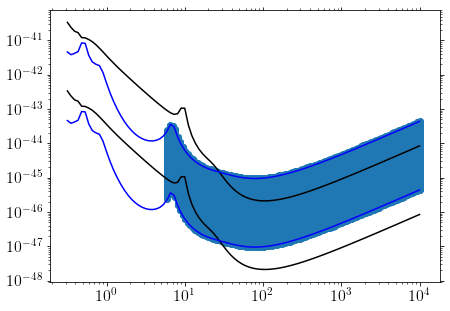

In [27]:
fig, ax = plt.subplots(figsize=(7,5))

ax.set_xscale('log')
ax.set_yscale('log')


plt.plot(m_lim, Sinj_lim, 'k', )
plt.plot(m_lim, Sinj_lim*100, 'k')
plt.plot(m_lim, Sinj_lim_1nm, 'blue', )
plt.plot(m_lim, Sinj_lim_1nm*100, 'blue')
plt.scatter(mass_1nm, sigmaSI_1nm)

plt.show()


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


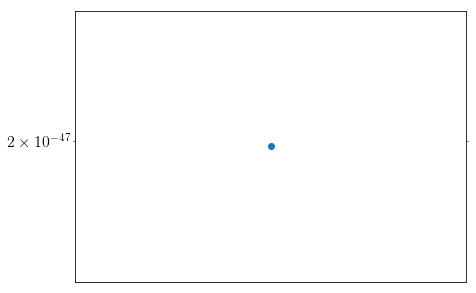

In [28]:
i = 5500
P0 = c_1nm[i,:]
pp, el_ind = shSinj_1nm.query_region(P0, sigma=3.0, d=1, return_indices = True)
# print(N[el_ind])
fig, ax = plt.subplots(figsize=(7,5))

ax.set_xscale('log')
ax.set_yscale('log')
plt.scatter(pp[:,0], pp[:,1])
plt.show()

In [29]:
m_listSinj_1nm = []
sigma_list_Sinj_1nm = []

for i in tqdm(range(len(c_1nm[:,0]))):
    P0 = c_1nm[i,:]
    
    if(P0[1] < 1e-35):
        pp, el_ind = shSinj_1nm.query_region(P0, sigma=2.0, d=1, return_indices = True)
        if pp.size == 0.0:
            continue
        if np.max(pp[:,0]) == np.max(mass_1nm):
            m_listSinj_1nm.append(c_1nm[i,0])
            sigma_list_Sinj_1nm.append(c_1nm[i,1])

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
100%|██████████| 10000/10000 [01:18<00:00, 126.85it/s]


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


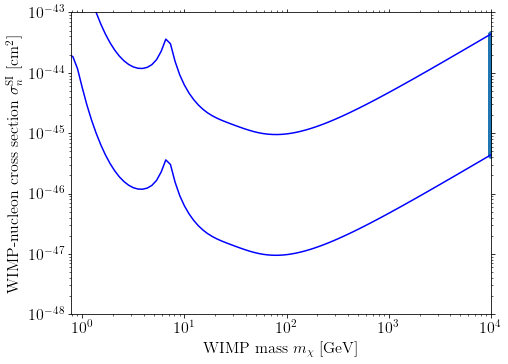

In [30]:
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
rc('font', size=16)
plt.figure(figsize=(7,5))
from scipy.stats import binned_statistic
ax = plt.gca()

ax.set_xscale('log')
ax.set_yscale('log')

plt.plot(m_lim, Sinj_lim_1nm, 'blue', )
plt.plot(m_lim, Sinj_lim_1nm*100, 'blue')

plt.scatter(m_listSinj_1nm, sigma_list_Sinj_1nm)

# percentile = lambda x: np.percentile(x, 99.)
# line, bins, _ = binned_statistic(m_listSinj_1nm, sigma_list_Sinj_1nm,
#                                  percentile, bins=np.logspace(np.log10(6),4.,num=60))
# bin_c = bins[:-1] + np.diff(bins)

# plt.plot(bin_c,line, 'k')
# temp = interp1d(m_lim, Sinj_lim_1nm)
# plt.fill_between(bin_c,line, temp(bin_c), linestyle='--', color='blue', alpha=0.5)
plt.xlabel(r'WIMP mass $m_\chi$ [GeV]')
plt.ylabel(r'WIMP-nucleon cross section $\sigma_n^{\mathrm{SI}}$ [cm$^2$]')
plt.xlim(np.log10(6),10000)
plt.ylim(1e-48,1e-43)
plt.tight_layout(pad=0.3)
plt.savefig("../plots/mass_reconstruction1nm.pdf")
plt.show()